In [54]:
### Load necessary libeary.

import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import roc_curve, auc
import keras as K
import matplotlib.pyplot as plt

Using TensorFlow backend.
D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type

In [5]:
### Load data.

data = pd.read_csv('part_train_data.csv')
data.shape

(99474, 301)

In [6]:
data.head(5)

### Origin darta has 297 features, one label.

,Unnamed: 0,id,date,f1,f2,f3,f4,f5,f6,f7,...,f289,f290,f291,f292,f293,f294,f295,f296,f297,label
0,656857,a08dfc51898f7056df3494c1ec079258aecea8be22c859...,20171030,1,1,0,0,100807.0,0,5,...,340.0,379.0,16.0,302.0,106.0,108.0,109.0,5.0,107.0,0
1,968151,d8a63c6251db058bc58e3ff629abb7acca2d34651cfa5e...,20170910,1,1,1,0,100804.0,1,7,...,302.0,302.0,117.0,302.0,220.0,220.0,220.0,86.0,220.0,0
2,55474,d3dfefae0c7e4d80481d074e262876564a26739fceb406...,20171008,0,1,1,0,100806.0,0,2,...,2.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,0
3,672510,ef6730b52e566f9ed3b5e29d0fd153c39d2aad5a6cabcf...,20171014,1,0,1,0,100806.0,1,5,...,302.0,301.0,184.0,302.0,189.0,189.0,189.0,128.0,188.0,0
4,185433,04ce161801e0368c4b5dda2d4f6d9852f8d69081364e3e...,20171020,1,0,0,1,100805.0,1,3,...,303.0,312.0,160.0,301.0,187.0,187.0,187.0,100.0,186.0,0


In [11]:
### Analysis of missing values.

col_list = list(data.columns )

del_list = []
for i in range( data.shape[1] ):
    miss_ratio = data[ col_list[i] ].isnull().sum()/data.shape[0] 
    if miss_ratio>0.5:
        del_list.append( col_list[i] )

In [12]:
### Ratio of missing values is over 0.5.
del_list

['f36',
 'f37',
 'f38',
 'f39',
 'f40',
 'f41',
 'f42',
 'f43',
 'f44',
 'f45',
 'f46',
 'f47']

In [28]:
### remove the row of missing label.
#### remove the row that ratio of nan value is over 0.5
#### Nan is filled by mean values.

def fill_col_null_with_mean(df):
    col_names = list(df.columns)
    for col in tqdm(col_names):
        if 'f' in col:  # to exclude: id date label 
            df[col] = df[col].transform(lambda x: x.fillna(x.mean()))
    return df

def clean_df(df, na_ratio=0.5):
    df_eff = df[df.label != -1]
    na_thres = int((1-0.5)*df.shape[0])
    df_dropna = df_eff.dropna(thresh = na_thres, axis =1)
    df_out = fill_col_null_with_mean(df_dropna)

    print('remove {} records without label.'.format(df.shape[0] - df_out.shape[0]))
    print('remove {} features where na ratio {}.'.format(df.shape[1] - df_out.shape[1], na_ratio))
    print(df_out.shape)
    df_out = df_out.drop(['Unnamed: 0', 'id', 'date'], axis=1)
    print(df_out.shape)
    return df_out

In [29]:
data_clean = clean_df(data)

  0%|          | 0/289 [00:00<?, ?it/s]D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
100%|██████████| 289/289 [00:01<00:00, 194.96it/s]


remove 463 records without label.
remove 12 features where na ratio 0.5.
(99011, 289)
(99011, 286)


In [30]:
data_clean.head(5)

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f289,f290,f291,f292,f293,f294,f295,f296,f297,label
0,1,1,0,0,100807.0,0,5,1,1,1,...,340.0,379.0,16.0,302.0,106.0,108.0,109.0,5.0,107.0,0
1,1,1,1,0,100804.0,1,7,1,1,0,...,302.0,302.0,117.0,302.0,220.0,220.0,220.0,86.0,220.0,0
2,0,1,1,0,100806.0,0,2,2,0,0,...,2.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,0
3,1,0,1,0,100806.0,1,5,2,1,2,...,302.0,301.0,184.0,302.0,189.0,189.0,189.0,128.0,188.0,0
4,1,0,0,1,100805.0,1,3,2,0,2,...,303.0,312.0,160.0,301.0,187.0,187.0,187.0,100.0,186.0,0


In [36]:
### split train and test dataset.

y = data_clean['label']
x = data_clean.drop( ['label'], axis=1 )
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.4 )
test_x.shape

(39605, 285)

In [42]:
#### Evaluate the performance of model.

def get_tpr(X_data, y_gt, model):

    # score = 0.4 * TPR1 + 0.3 * TPR2 + 0.3 * TPR3
    
    probas = model.predict_proba(X_data)
    fpr, tpr, thresholds = roc_curve(y_gt, probas[:, 1],pos_label=1)

    fpr_dic = {'r1':0.001, 'r2':0.005, 'r3':0.01}
    tpr_dic = {}
    
    for k, fpr_thres in fpr_dic.items():
        index = np.argmin(abs(fpr - fpr_thres))
        tpr_dic[k] = tpr[index]

    final_score = 0.4*tpr_dic['r1'] + 0.3*tpr_dic['r2'] + 0.3*tpr_dic['r3']

    print('tpr at each level: ')
    print(tpr_dic)
    print('final score \t: {} '.format(final_score))
    
    ### plot roc curve.

    plt.title('ROC Curve.')
    plt.plot(fpr, tpr, 'b', label='Score = %0.2f'% final_score)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('tpr')
    plt.xlabel('fpr')
    plt.show()    
    
    return tpr_dic, final_score

tpr at each level: 
{'r1': 0.0, 'r2': 0.4176470588235294, 'r3': 0.4176470588235294}
final score 	: 0.25058823529411767 


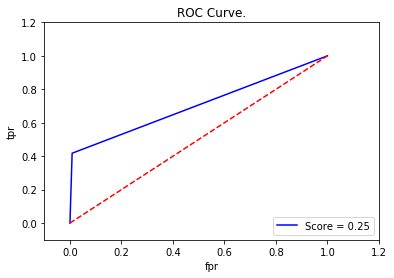

({'r1': 0.0, 'r2': 0.4176470588235294, 'r3': 0.4176470588235294},
 0.25058823529411767)

In [43]:
### Train model using Decision Tree.

#### The score of Decision Tree is: 0.29

dt = DecisionTreeClassifier()
dt.fit( train_x, train_y )
get_tpr(test_x, test_y, dt)

tpr at each level: 
{'r1': 0.3254901960784314, 'r2': 0.6039215686274509, 'r3': 0.7254901960784313}
final score 	: 0.5290196078431373 


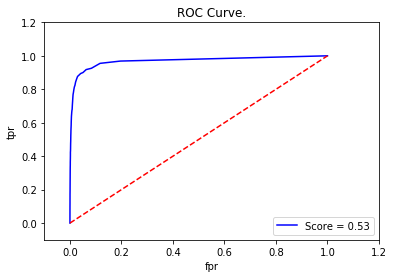

({'r1': 0.3254901960784314,
  'r2': 0.6039215686274509,
  'r3': 0.7254901960784313},
 0.5290196078431373)

In [44]:
### Train model using Random Forest.

#### The score of Random Forest is: 0.53

rf = RandomForestClassifier()
rf.fit( train_x, train_y )
get_tpr(test_x, test_y, rf)

tpr at each level: 
{'r1': 0.1607843137254902, 'r2': 0.43529411764705883, 'r3': 0.5686274509803921}
final score 	: 0.36549019607843136 


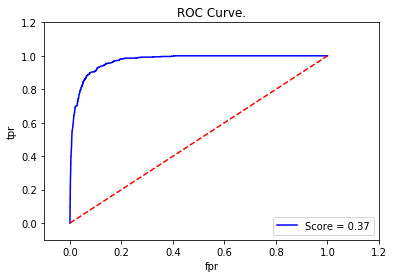

({'r1': 0.1607843137254902,
  'r2': 0.43529411764705883,
  'r3': 0.5686274509803921},
 0.36549019607843136)

In [46]:
### Train model using AdaBoost

#### The score of AdaBoost is: 0.366

ada = AdaBoostClassifier()
ada.fit( train_x, train_y )
get_tpr(test_x, test_y, ada)

tpr at each level: 
{'r1': 0.20392156862745098, 'r2': 0.4803921568627451, 'r3': 0.6254901960784314}
final score 	: 0.41333333333333333 


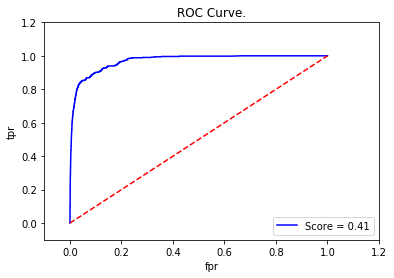

({'r1': 0.20392156862745098,
  'r2': 0.4803921568627451,
  'r3': 0.6254901960784314},
 0.41333333333333333)

In [47]:
### Train model using GBDT.

#### The score of GBDT is: 0.41

gbdt = GradientBoostingClassifier()
gbdt.fit( train_x, train_y )
get_tpr(test_x, test_y, gbdt)

In [71]:
#### GBDT + MLP.
from sklearn.feature_selection import SelectFromModel
gbdt = GradientBoostingClassifier()
gbdt.fit(train_x, train_y)
model = SelectFromModel(gbdt, prefit=True)
select_train_x = model.transform( train_x )
select_test_x = model.transform(test_x)

tpr at each level: 
{'r1': 0.14313725490196078, 'r2': 0.3176470588235294, 'r3': 0.4294117647058823}
final score 	: 0.28137254901960784 


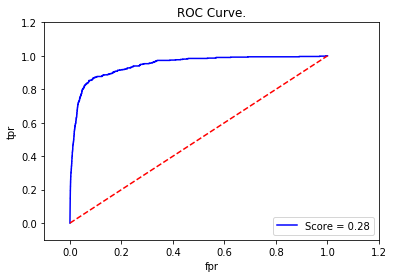

({'r1': 0.14313725490196078,
  'r2': 0.3176470588235294,
  'r3': 0.4294117647058823},
 0.28137254901960784)

In [73]:
### Train model using MLP.

mlp = MLPClassifier()
mlp.fit( select_train_x, train_y )
get_tpr(select_test_x, test_y, mlp)

- Using GBDT, performance of MLP is higher 0.13 than that only using MLP.

In [93]:
#### FBDT + dnn.
from keras import metrics
metrics.

In [79]:
### Train model using DNN.
init = K.initializers.glorot_uniform(seed=1)
simple_adam = K.optimizers.Adam()
model = K.models.Sequential()
model.add(K.layers.Dense(units=5, input_dim=60, kernel_initializer=init, activation='relu'))
model.add(K.layers.Dense(units=6, kernel_initializer=init, activation='relu'))
model.add(K.layers.Dense(units=1, kernel_initializer=init, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=simple_adam, metrics=['accuracy'])

#### The score of DNN is: 0.53
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb.fit(train_y)
train_labels = lb.transform(train_y)
test_labels = lb.transform(test_y)

print()

b_size = 1
max_epochs = 100
print("Starting training ")
h = model.fit(select_train_x, train_labels, batch_size=b_size, epochs=max_epochs, shuffle=True, verbose=1)
print("Training finished \n")




Starting training 
Epoch 1/1


 4859/59406 [=>............................] - ETA: 13:17:23 - loss: 15.9424 - acc: 0.0000e+ - ETA: 33:54 - loss: 15.3047 - acc: 0.0400       - ETA: 18:43 - loss: 15.2781 - acc: 0.041 - ETA: 13:21 - loss: 15.4933 - acc: 0.028 - ETA: 10:18 - loss: 15.6137 - acc: 0.020 - ETA: 8:31 - loss: 15.6832 - acc: 0.016 - ETA: 7:22 - loss: 15.7284 - acc: 0.01 - ETA: 6:34 - loss: 15.5780 - acc: 0.02 - ETA: 5:59 - loss: 15.5438 - acc: 0.02 - ETA: 5:33 - loss: 15.5881 - acc: 0.02 - ETA: 5:14 - loss: 15.5567 - acc: 0.02 - ETA: 4:56 - loss: 15.5361 - acc: 0.02 - ETA: 4:40 - loss: 15.5182 - acc: 0.02 - ETA: 4:24 - loss: 15.5580 - acc: 0.02 - ETA: 4:16 - loss: 15.5820 - acc: 0.02 - ETA: 4:08 - loss: 15.6050 - acc: 0.02 - ETA: 4:00 - loss: 15.5854 - acc: 0.02 - ETA: 3:54 - loss: 15.5311 - acc: 0.02 - ETA: 3:48 - loss: 15.5532 - acc: 0.02 - ETA: 3:42 - loss: 15.5738 - acc: 0.02 - ETA: 3:38 - loss: 15.5909 - acc: 0.02 - ETA: 3:33 - loss: 15.6078 - acc: 0.02 - ETA: 3:29 - loss: 15.6220 - acc: 0.02 - ETA: 3:27

20083/59406 [=========>....................] - ETA: 1:35 - loss: 3.2702 - acc: 0.795 - ETA: 1:35 - loss: 3.2652 - acc: 0.795 - ETA: 1:35 - loss: 3.2595 - acc: 0.795 - ETA: 1:35 - loss: 3.2539 - acc: 0.796 - ETA: 1:35 - loss: 3.2481 - acc: 0.796 - ETA: 1:34 - loss: 3.2425 - acc: 0.796 - ETA: 1:34 - loss: 3.2370 - acc: 0.797 - ETA: 1:34 - loss: 3.2316 - acc: 0.797 - ETA: 1:34 - loss: 3.2263 - acc: 0.797 - ETA: 1:34 - loss: 3.2210 - acc: 0.798 - ETA: 1:34 - loss: 3.2160 - acc: 0.798 - ETA: 1:34 - loss: 3.2105 - acc: 0.798 - ETA: 1:34 - loss: 3.2050 - acc: 0.799 - ETA: 1:34 - loss: 3.2011 - acc: 0.799 - ETA: 1:34 - loss: 3.1954 - acc: 0.799 - ETA: 1:34 - loss: 3.1898 - acc: 0.800 - ETA: 1:34 - loss: 3.1843 - acc: 0.800 - ETA: 1:34 - loss: 3.1806 - acc: 0.800 - ETA: 1:34 - loss: 3.1759 - acc: 0.800 - ETA: 1:33 - loss: 3.1705 - acc: 0.801 - ETA: 1:33 - loss: 3.1663 - acc: 0.801 - ETA: 1:33 - loss: 3.1604 - acc: 0.801 - ETA: 1:33 - loss: 3.1551 - acc: 0.802 - ETA: 1:33 - loss: 3.1500 - acc: 0

25250/59406 [===========>..................] - ETA: 1:23 - loss: 2.4937 - acc: 0.843 - ETA: 1:23 - loss: 2.4911 - acc: 0.843 - ETA: 1:23 - loss: 2.4879 - acc: 0.844 - ETA: 1:23 - loss: 2.4862 - acc: 0.844 - ETA: 1:23 - loss: 2.4854 - acc: 0.844 - ETA: 1:23 - loss: 2.4833 - acc: 0.844 - ETA: 1:23 - loss: 2.4803 - acc: 0.844 - ETA: 1:22 - loss: 2.4773 - acc: 0.844 - ETA: 1:22 - loss: 2.4745 - acc: 0.844 - ETA: 1:22 - loss: 2.4712 - acc: 0.845 - ETA: 1:22 - loss: 2.4683 - acc: 0.845 - ETA: 1:22 - loss: 2.4654 - acc: 0.845 - ETA: 1:22 - loss: 2.4625 - acc: 0.845 - ETA: 1:22 - loss: 2.4595 - acc: 0.845 - ETA: 1:22 - loss: 2.4571 - acc: 0.846 - ETA: 1:22 - loss: 2.4542 - acc: 0.846 - ETA: 1:22 - loss: 2.4513 - acc: 0.846 - ETA: 1:22 - loss: 2.4489 - acc: 0.846 - ETA: 1:22 - loss: 2.4461 - acc: 0.846 - ETA: 1:22 - loss: 2.4429 - acc: 0.846 - ETA: 1:22 - loss: 2.4397 - acc: 0.847 - ETA: 1:22 - loss: 2.4362 - acc: 0.847 - ETA: 1:22 - loss: 2.4327 - acc: 0.847 - ETA: 1:21 - loss: 2.4295 - acc: 0

30414/59406 [==============>...............] - ETA: 1:11 - loss: 2.0260 - acc: 0.873 - ETA: 1:11 - loss: 2.0239 - acc: 0.873 - ETA: 1:11 - loss: 2.0218 - acc: 0.873 - ETA: 1:11 - loss: 2.0205 - acc: 0.873 - ETA: 1:11 - loss: 2.0187 - acc: 0.873 - ETA: 1:11 - loss: 2.0172 - acc: 0.873 - ETA: 1:11 - loss: 2.0152 - acc: 0.873 - ETA: 1:11 - loss: 2.0137 - acc: 0.873 - ETA: 1:11 - loss: 2.0126 - acc: 0.873 - ETA: 1:11 - loss: 2.0112 - acc: 0.874 - ETA: 1:11 - loss: 2.0093 - acc: 0.874 - ETA: 1:11 - loss: 2.0070 - acc: 0.874 - ETA: 1:11 - loss: 2.0052 - acc: 0.874 - ETA: 1:11 - loss: 2.0032 - acc: 0.874 - ETA: 1:10 - loss: 2.0013 - acc: 0.874 - ETA: 1:10 - loss: 1.9992 - acc: 0.874 - ETA: 1:10 - loss: 1.9975 - acc: 0.874 - ETA: 1:10 - loss: 1.9957 - acc: 0.874 - ETA: 1:10 - loss: 1.9938 - acc: 0.875 - ETA: 1:10 - loss: 1.9916 - acc: 0.875 - ETA: 1:10 - loss: 1.9898 - acc: 0.875 - ETA: 1:10 - loss: 1.9879 - acc: 0.875 - ETA: 1:10 - loss: 1.9858 - acc: 0.875 - ETA: 1:10 - loss: 1.9838 - acc: 0

35881/59406 [=================>............] - ETA: 1:00 - loss: 1.7164 - acc: 0.892 - ETA: 1:00 - loss: 1.7150 - acc: 0.892 - ETA: 1:00 - loss: 1.7136 - acc: 0.892 - ETA: 1:00 - loss: 1.7123 - acc: 0.892 - ETA: 1:00 - loss: 1.7107 - acc: 0.892 - ETA: 1:00 - loss: 1.7100 - acc: 0.892 - ETA: 1:00 - loss: 1.7085 - acc: 0.892 - ETA: 1:00 - loss: 1.7074 - acc: 0.893 - ETA: 1:00 - loss: 1.7060 - acc: 0.893 - ETA: 1:00 - loss: 1.7045 - acc: 0.893 - ETA: 1:00 - loss: 1.7037 - acc: 0.893 - ETA: 59s - loss: 1.7022 - acc: 0.893 - ETA: 59s - loss: 1.7008 - acc: 0.89 - ETA: 59s - loss: 1.6993 - acc: 0.89 - ETA: 59s - loss: 1.6978 - acc: 0.89 - ETA: 59s - loss: 1.6964 - acc: 0.89 - ETA: 59s - loss: 1.6954 - acc: 0.89 - ETA: 59s - loss: 1.6938 - acc: 0.89 - ETA: 59s - loss: 1.6923 - acc: 0.89 - ETA: 59s - loss: 1.6909 - acc: 0.89 - ETA: 59s - loss: 1.6899 - acc: 0.89 - ETA: 59s - loss: 1.6886 - acc: 0.89 - ETA: 59s - loss: 1.6878 - acc: 0.89 - ETA: 59s - loss: 1.6871 - acc: 0.89 - ETA: 59s - loss: 1

41387/59406 [===================>..........] - ETA: 48s - loss: 1.4913 - acc: 0.90 - ETA: 48s - loss: 1.4901 - acc: 0.90 - ETA: 48s - loss: 1.4889 - acc: 0.90 - ETA: 48s - loss: 1.4884 - acc: 0.90 - ETA: 48s - loss: 1.4878 - acc: 0.90 - ETA: 48s - loss: 1.4872 - acc: 0.90 - ETA: 48s - loss: 1.4861 - acc: 0.90 - ETA: 48s - loss: 1.4851 - acc: 0.90 - ETA: 48s - loss: 1.4841 - acc: 0.90 - ETA: 48s - loss: 1.4831 - acc: 0.90 - ETA: 48s - loss: 1.4821 - acc: 0.90 - ETA: 48s - loss: 1.4811 - acc: 0.90 - ETA: 48s - loss: 1.4801 - acc: 0.90 - ETA: 48s - loss: 1.4795 - acc: 0.90 - ETA: 48s - loss: 1.4789 - acc: 0.90 - ETA: 48s - loss: 1.4784 - acc: 0.90 - ETA: 47s - loss: 1.4777 - acc: 0.90 - ETA: 47s - loss: 1.4766 - acc: 0.90 - ETA: 47s - loss: 1.4754 - acc: 0.90 - ETA: 47s - loss: 1.4748 - acc: 0.90 - ETA: 47s - loss: 1.4737 - acc: 0.90 - ETA: 47s - loss: 1.4728 - acc: 0.90 - ETA: 47s - loss: 1.4721 - acc: 0.90 - ETA: 47s - loss: 1.4715 - acc: 0.90 - ETA: 47s - loss: 1.4714 - acc: 0.90 - ETA

46636/59406 [======================>.......] - ETA: 37s - loss: 1.3211 - acc: 0.91 - ETA: 37s - loss: 1.3204 - acc: 0.91 - ETA: 37s - loss: 1.3199 - acc: 0.91 - ETA: 37s - loss: 1.3192 - acc: 0.91 - ETA: 36s - loss: 1.3184 - acc: 0.91 - ETA: 36s - loss: 1.3176 - acc: 0.91 - ETA: 36s - loss: 1.3173 - acc: 0.91 - ETA: 36s - loss: 1.3164 - acc: 0.91 - ETA: 36s - loss: 1.3156 - acc: 0.91 - ETA: 36s - loss: 1.3149 - acc: 0.91 - ETA: 36s - loss: 1.3141 - acc: 0.91 - ETA: 36s - loss: 1.3134 - acc: 0.91 - ETA: 36s - loss: 1.3126 - acc: 0.91 - ETA: 36s - loss: 1.3118 - acc: 0.91 - ETA: 36s - loss: 1.3109 - acc: 0.91 - ETA: 36s - loss: 1.3102 - acc: 0.91 - ETA: 36s - loss: 1.3097 - acc: 0.91 - ETA: 36s - loss: 1.3088 - acc: 0.91 - ETA: 36s - loss: 1.3079 - acc: 0.91 - ETA: 36s - loss: 1.3070 - acc: 0.91 - ETA: 36s - loss: 1.3063 - acc: 0.91 - ETA: 36s - loss: 1.3054 - acc: 0.91 - ETA: 36s - loss: 1.3045 - acc: 0.91 - ETA: 35s - loss: 1.3040 - acc: 0.91 - ETA: 35s - loss: 1.3036 - acc: 0.91 - ETA

51957/59406 [=========================>....] - ETA: 26s - loss: 1.1908 - acc: 0.92 - ETA: 26s - loss: 1.1909 - acc: 0.92 - ETA: 26s - loss: 1.1906 - acc: 0.92 - ETA: 26s - loss: 1.1900 - acc: 0.92 - ETA: 26s - loss: 1.1894 - acc: 0.92 - ETA: 26s - loss: 1.1887 - acc: 0.92 - ETA: 26s - loss: 1.1884 - acc: 0.92 - ETA: 26s - loss: 1.1878 - acc: 0.92 - ETA: 26s - loss: 1.1873 - acc: 0.92 - ETA: 25s - loss: 1.1867 - acc: 0.92 - ETA: 25s - loss: 1.1862 - acc: 0.92 - ETA: 25s - loss: 1.1863 - acc: 0.92 - ETA: 25s - loss: 1.1857 - acc: 0.92 - ETA: 25s - loss: 1.1855 - acc: 0.92 - ETA: 25s - loss: 1.1850 - acc: 0.92 - ETA: 25s - loss: 1.1843 - acc: 0.92 - ETA: 25s - loss: 1.1841 - acc: 0.92 - ETA: 25s - loss: 1.1842 - acc: 0.92 - ETA: 25s - loss: 1.1839 - acc: 0.92 - ETA: 25s - loss: 1.1832 - acc: 0.92 - ETA: 25s - loss: 1.1829 - acc: 0.92 - ETA: 25s - loss: 1.1822 - acc: 0.92 - ETA: 25s - loss: 1.1815 - acc: 0.92 - ETA: 25s - loss: 1.1809 - acc: 0.92 - ETA: 25s - loss: 1.1806 - acc: 0.92 - ETA

57436/59406 [============================>.] - ETA: 15s - loss: 1.0900 - acc: 0.93 - ETA: 15s - loss: 1.0897 - acc: 0.93 - ETA: 15s - loss: 1.0892 - acc: 0.93 - ETA: 15s - loss: 1.0887 - acc: 0.93 - ETA: 15s - loss: 1.0884 - acc: 0.93 - ETA: 15s - loss: 1.0879 - acc: 0.93 - ETA: 15s - loss: 1.0873 - acc: 0.93 - ETA: 15s - loss: 1.0868 - acc: 0.93 - ETA: 14s - loss: 1.0864 - acc: 0.93 - ETA: 14s - loss: 1.0859 - acc: 0.93 - ETA: 14s - loss: 1.0853 - acc: 0.93 - ETA: 14s - loss: 1.0852 - acc: 0.93 - ETA: 14s - loss: 1.0849 - acc: 0.93 - ETA: 14s - loss: 1.0847 - acc: 0.93 - ETA: 14s - loss: 1.0845 - acc: 0.93 - ETA: 14s - loss: 1.0840 - acc: 0.93 - ETA: 14s - loss: 1.0835 - acc: 0.93 - ETA: 14s - loss: 1.0830 - acc: 0.93 - ETA: 14s - loss: 1.0827 - acc: 0.93 - ETA: 14s - loss: 1.0820 - acc: 0.93 - ETA: 14s - loss: 1.0815 - acc: 0.93 - ETA: 14s - loss: 1.0809 - acc: 0.93 - ETA: 14s - loss: 1.0807 - acc: 0.93 - ETA: 14s - loss: 1.0804 - acc: 0.93 - ETA: 14s - loss: 1.0802 - acc: 0.93 - ETA

59406/59406 [==============================] - ETA: 4s - loss: 1.0023 - acc: 0.937 - ETA: 3s - loss: 1.0018 - acc: 0.937 - ETA: 3s - loss: 1.0017 - acc: 0.937 - ETA: 3s - loss: 1.0013 - acc: 0.937 - ETA: 3s - loss: 1.0008 - acc: 0.937 - ETA: 3s - loss: 1.0007 - acc: 0.937 - ETA: 3s - loss: 1.0002 - acc: 0.937 - ETA: 3s - loss: 0.9998 - acc: 0.937 - ETA: 3s - loss: 0.9999 - acc: 0.937 - ETA: 3s - loss: 0.9995 - acc: 0.937 - ETA: 3s - loss: 0.9990 - acc: 0.937 - ETA: 3s - loss: 0.9986 - acc: 0.937 - ETA: 3s - loss: 0.9987 - acc: 0.937 - ETA: 3s - loss: 0.9985 - acc: 0.937 - ETA: 3s - loss: 0.9981 - acc: 0.937 - ETA: 3s - loss: 0.9976 - acc: 0.937 - ETA: 3s - loss: 0.9971 - acc: 0.937 - ETA: 3s - loss: 0.9967 - acc: 0.937 - ETA: 3s - loss: 0.9965 - acc: 0.937 - ETA: 3s - loss: 0.9963 - acc: 0.937 - ETA: 2s - loss: 0.9959 - acc: 0.937 - ETA: 2s - loss: 0.9957 - acc: 0.937 - ETA: 2s - loss: 0.9958 - acc: 0.937 - ETA: 2s - loss: 0.9953 - acc: 0.937 - ETA: 2s - loss: 0.9951 - acc: 0.937 - ETA

[0.00000000e+00 5.88310526e-04 8.44097711e-04 8.69676429e-04
 1.00000000e+00] [0.         0.00588235 0.00588235 0.00588235 1.        ] [2.0000000e+00 1.0000000e+00 2.9458225e-01 3.9806012e-20 0.0000000e+00]
tpr at each level: 
{'r1': 0.0058823529411764705, 'r2': 0.0058823529411764705, 'r3': 0.0058823529411764705}
final score 	: 0.0058823529411764705 


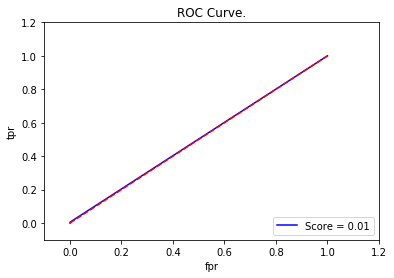

In [92]:
### Evaluate the performance of DNN model.

probas = model.predict(select_test_x)

fpr, tpr, thresholds = roc_curve(test_y, probas[:, 0],pos_label=1)

fpr_dic = {'r1':0.001, 'r2':0.005, 'r3':0.01}
tpr_dic = {}

for k, fpr_thres in fpr_dic.items():
    index = np.argmin(abs(fpr - fpr_thres))
    tpr_dic[k] = tpr[index]
print( fpr, tpr, thresholds )
final_score = 0.4*tpr_dic['r1'] + 0.3*tpr_dic['r2'] + 0.3*tpr_dic['r3']

print('tpr at each level: ')
print(tpr_dic)
print('final score \t: {} '.format(final_score))

### plot roc curve.

plt.title('ROC Curve.')
plt.plot(fpr, tpr, 'b', label='Score = %0.2f'% final_score)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.show()    